In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath("AMUSE_project_YESSIR"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from src.cluster_cloud_initialization import *
from src.molecular_cloud_initialization import *

In [2]:
cloud = make_molecular_cloud(10000,100000 | units.MSun, 200 | units.pc, 999)

Time 0.2 Myr
Time 0.4 Myr
Time 0.6000000000000001 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.5999999999999999 Myr
Time 1.7999999999999998 Myr
Time 1.9999999999999998 Myr
Time 2.1999999999999997 Myr
CPU times: user 1.16 s, sys: 702 ms, total: 1.87 s
Wall time: 2min 32s


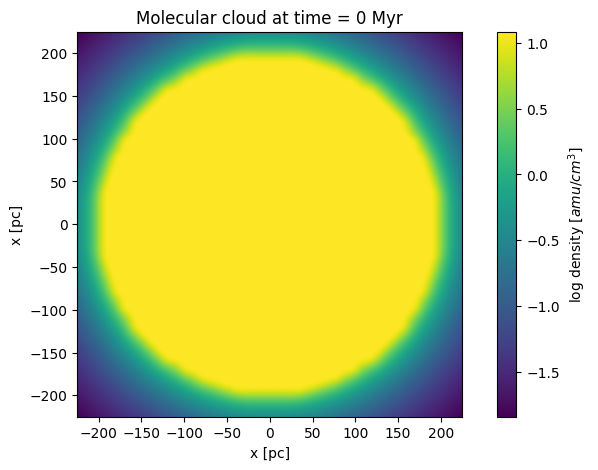

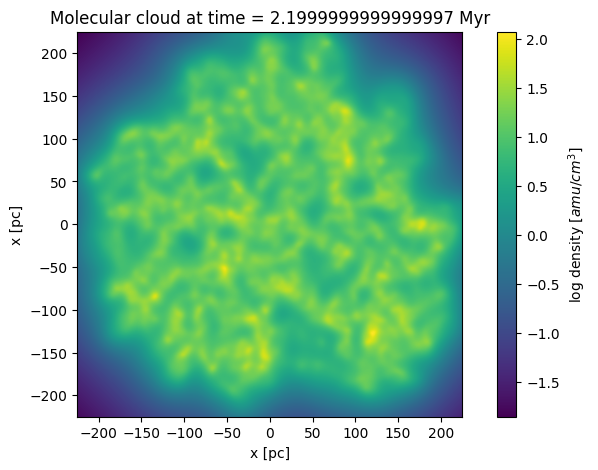

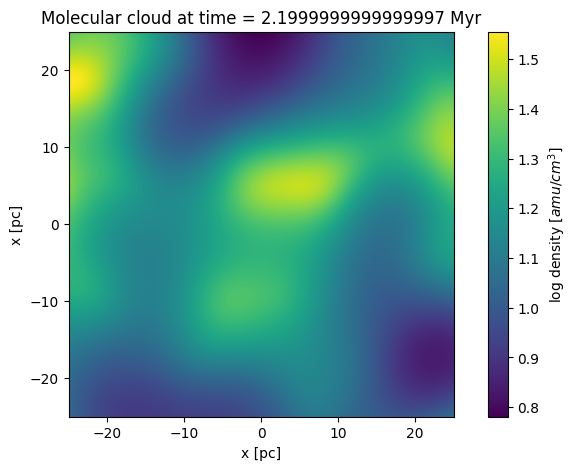

In [3]:
%%time

particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

In [4]:
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
import numpy as np

In [5]:
bodies = Particles(1)
bodies[0].name = "star"
bodies[0].mass = 50 |units.MSun
bodies[0].radius = 5 | units.RSun 
bodies[0].position = (0, 0, 1) * (250 | units.pc)
bodies[0].velocity = (0, -1, 0) * (200 | units.kms)
converter = nbody_system.nbody_to_si(bodies[0].mass.sum(), bodies[0].position.length())

In [7]:
from amuse.community.bhtree.interface import BHTree

gravity = BHTree(converter)
gravity.particles.add_particles(bodies)
channel = {"from star": bodies.new_channel_to(gravity.particles),
            "to_star": gravity.particles.new_channel_to(bodies)}

In [9]:
from amuse.community.fi.interface import Fi

t_end = ((2*bodies[0].position[2]) / np.abs(bodies[0].velocity[1])).in_(units.Myr)
dt = t_end*0.1

hydro = Fi(converter_cloud)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = False
hydro.parameters.integrate_entropy_flag = True
hydro.parameters.timestep = 0.01*dt 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 1 | units.RSun
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

hydro.gas_particles.add_particles(particles_cloud)

channel.update({"from_cloud": particles_cloud.new_channel_to(hydro.particles)})
channel.update({"to_cloud": hydro.particles.new_channel_to(particles_cloud)})
channel.update({"from_moon": bodies.new_channel_to(hydro.dm_particles)})
channel.update({"to_moon": hydro.dm_particles.new_channel_to(bodies)})

CodeException: Exception when calling function 'commit_parameters', of code 'FiInterface', exception was 'lost connection to code'